In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from keras.layers import Dense
from keras.models import Sequential,Model

from tensorflow.keras.optimizers import Adam

In [2]:
class GaussianNoise(tf.keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super(GaussianNoise, self).__init__(**kwargs)
        self.stddev = stddev

    def call(self, inputs, training=None):
        if 1 or training:
            noise = tf.random.normal(tf.shape(inputs), stddev=self.stddev)
            return inputs + noise
        return inputs

    def get_config(self):
        config = super(GaussianNoise, self).get_config()
        config.update({'stddev': self.stddev})
        return config
    
    
class L2Normalization(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        
        super(L2Normalization, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.nn.l2_normalize(inputs, axis=-1)

    def get_config(self):
        return super(L2Normalization, self).get_config()
    

def generate_nakagami_samples(m, omega, shape):

    return tf.random.gamma(shape, m, 1/omega) ** 0.5
    
class NakagamiNoiseLayer(tf.keras.layers.Layer):
    def __init__(self, distribution_params, **kwargs):
        super(NakagamiNoiseLayer, self).__init__(**kwargs)
        self.distribution_params = distribution_params

    def call(self, inputs, training=None):
        if  1 or training:
            # noise = tf.random.normal(tf.shape(inputs), **self.distribution_params)
            if tf.shape(inputs)[0] == None:
                noise = generate_nakagami_samples(m = self.distribution_params["m"], 
                                              omega = self.distribution_params["omega"], 
                                              shape = tf.shape(inputs))
            else:
                noise = generate_nakagami_samples(m = self.distribution_params["m"], 
                                              omega = self.distribution_params["omega"], 
                                              shape = tf.shape(inputs)[1:])
            return inputs * noise
        
        else:
            return inputs
        
        





In [3]:
# generating the data set
k = 3
M = 2**k


n_train = 10_000 * M

x_train = np.array(np.random.rand(n_train,k)<0.5).astype(np.float32)
y_train = x_train





In [4]:
accuracies = []
models = []
attempts = 0
while True:
        attempts += 1
        print(f"-------  start of attempt : {attempts} ----------")
        AE = Sequential([
            

                                Dense(2*k, activation='tanh',input_shape=(k,)),
                                Dense(2*k, activation='tanh'),

                                Dense(2, activation='linear'),
                                L2Normalization(name="normalization_layer"),


                                NakagamiNoiseLayer({"omega":1,"m":5}),
                                GaussianNoise(stddev=0.1,name="channel"),

                                L2Normalization(name="normalization_layer_at_rx"),

                                Dense(2*k, activation='tanh'),
                                Dense(k, activation='sigmoid')



                        ])

        AE.build()
        #     AE.summary()
        
        AE.compile(optimizer=Adam(learning_rate=1e-2),loss="binary_crossentropy")
        AE.fit(x_train,y_train,epochs=10,)
        
        preds = AE.predict(x_train)>0.5
        accuracy = np.mean( preds == y_train  )
        print(f"accuracy = {accuracy}")
        
        accuracies.append(accuracy)
        models.append(AE)
        
        if accuracy > 0.97 or attempts >= 5:
            break
        
        
        
print("Accuracies: ", accuracies)

-------  start of attempt : 1 ----------
Epoch 1/10
2500/2500 [==============================] - 12s 4ms/step - loss: 0.0525
Epoch 2/10
2500/2500 [==============================] - 8s 3ms/step - loss: 0.0042
Epoch 3/10
2500/2500 [==============================] - 11s 4ms/step - loss: 0.0031
Epoch 4/10
2500/2500 [==============================] - 11s 5ms/step - loss: 0.0014
Epoch 5/10
2500/2500 [==============================] - 12s 5ms/step - loss: 0.0011
Epoch 6/10
2500/2500 [==============================] - 13s 5ms/step - loss: 0.0016
Epoch 7/10
2500/2500 [==============================] - 13s 5ms/step - loss: 0.0018
Epoch 8/10
2500/2500 [==============================] - 11s 4ms/step - loss: 0.0015
Epoch 9/10
2500/2500 [==============================] - 11s 5ms/step - loss: 0.0013
Epoch 10/10
2500/2500 [==============================] - 9s 3ms/step
accuracy = 0.9998291666666667
Accuracies:  [0.9998291666666667]


In [5]:
# select the best out of all the AE models saved in AE
bestIndex = np.argmax(accuracies)
print("best accuracy: ", max(accuracies))
AE = models[bestIndex]

best accuracy:  0.9998291666666667


In [6]:
# bc = before_channel.predict(np.array([
    
#     [0,0],
#     [0,1],
#     [1,0],
#     [1,1]
  
    
# ]))



# bc = before_channel.predict(np.array([

#             [0,0,0,0],
#             [0,0,0,1],
#             [0,0,1,0],
#             [0,0,1,1],
#             [0,1,0,0],
#             [0,1,0,1],
#             [0,1,1,0],
#             [0,1,1,1],
#             [1,0,0,0],
#             [1,0,0,1],
#             [1,0,1,0],
#             [1,0,1,1],
#             [1,1,0,0],
#             [1,1,0,1],
#             [1,1,1,0],
#             [1,1,1,1]
    
# ]))




16/16 [==============================] - 0s 3ms/step


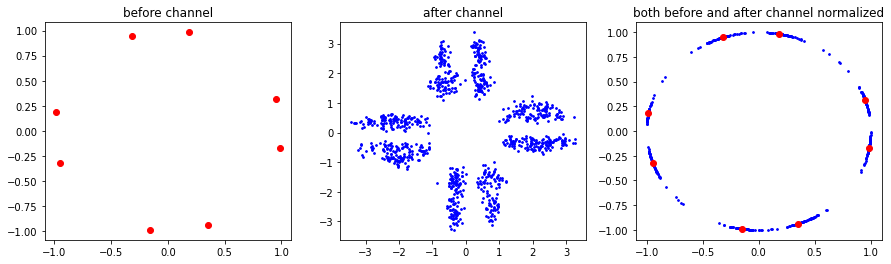

In [7]:


before_channel = Model(inputs=AE.input,
                                 outputs=AE.get_layer('normalization_layer').output)

after_channel  = Model(inputs=AE.input,
                                 outputs=AE.get_layer('channel').output)

after_channel_normalized = Model(inputs=AE.input,
                                 outputs=AE.get_layer('normalization_layer_at_rx').output)
    
    
bc = before_channel.predict(np.array([
   [0,0,0],
    [0,0,1],
    [0,1,0],
    [0,1,1],
    [1,0,0],
    [1,0,1],
    [1,1,0],
    [1,1,1],
    
  
  
    
]))
    

ac = after_channel.predict(x_train[:1000,:])
acn = after_channel_normalized.predict(x_train[:500,:])


fig,ax = plt.subplots(1,3,figsize=(15,4))
ax[0].scatter(bc[:,0],bc[:,1],c="red")
ax[0].set_title("before channel")


ax[1].scatter(ac[:,0],ac[:,1],c="blue",s=3)
ax[1].set_title("after channel")


ax[2].scatter(acn[:,0],acn[:,1],c="blue",s=3)
ax[2].scatter(bc[:,0],bc[:,1],c="red") # seconded to avoid occlusion
ax[2].set_title("both before and after channel normalized")


plt.show()

In [8]:



# # Example usage:
# m = 1.5  # Shape parameter
# omega = 2.0  # Scale parameter
# num_samples = 1000
# nakagami_samples = generate_nakagami_samples((None,num_samples,),m, omega)


# # Compute the histogram
# hist, bins = np.histogram(nakagami_samples, bins=20)  # Adjust the number of bins as needed

# # Plot the histogram
# plt.figure(figsize=(8, 6))
# plt.hist(nakagami_samples, bins=20, color='blue', alpha=0.7)  # Plot the histogram bars
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.title('Histogram of Nakagami Samples')
# plt.grid(True)
# plt.show()

In [9]:
bc

array([[-0.1521079 , -0.98836386],
       [ 0.94829947,  0.3173768 ],
       [-0.98284256,  0.18444666],
       [-0.31813422,  0.9480456 ],
       [ 0.35015202, -0.9366929 ],
       [ 0.9856024 , -0.16907974],
       [-0.9468675 , -0.32162356],
       [ 0.18273114,  0.98316294]], dtype=float32)